# **1. Import Library**

In [ ]:
# Import library
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# **2. Load Dataset**

In [ ]:
df = pd.read_csv('/content/user_preferences.csv')
tourism_df = pd.read_excel('/content/transformed.xlsx')

# **3. EDA**


1. Dataset Overview:
Number of unique users: 100
Number of unique places: 214
Total interactions: 1000

2. Rating Distribution:
rating
1    190
2    186
3    181
4    220
5    223
Name: count, dtype: int64

3. Liked Distribution:
liked
0    513
1    487
Name: count, dtype: int64

4. Correlation between Rating and Liked: -0.043

5. User Activity Statistics:
Average visits per user: 10.00
Min visits per user: 4
Max visits per user: 19

6. Place Popularity Statistics:
Average visitors per place: 4.67
Min visitors per place: 1
Max visitors per place: 11


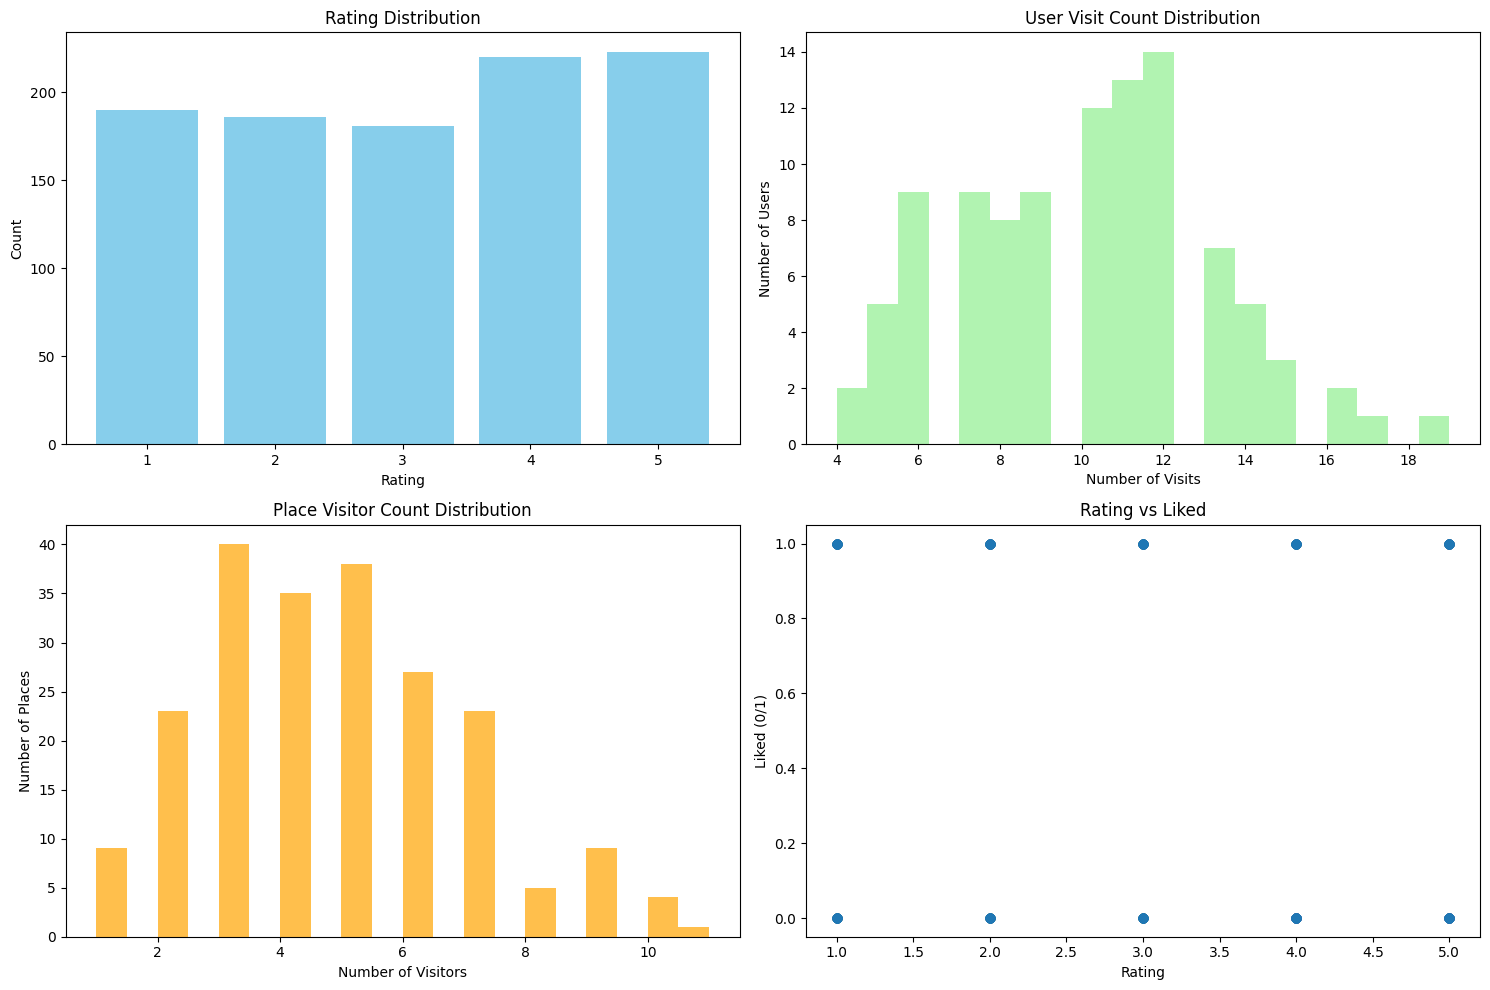

In [ ]:
# Basic statistics
print("\n1. Dataset Overview:")
print(f"Number of unique users: {df['user_id'].nunique()}")
print(f"Number of unique places: {df['place_id'].nunique()}")
print(f"Total interactions: {len(df)}")

# Rating distribution
print("\n2. Rating Distribution:")
rating_dist = df['rating'].value_counts().sort_index()
print(rating_dist)

# Liked distribution
print("\n3. Liked Distribution:")
liked_dist = df['liked'].value_counts()
print(liked_dist)

# Correlation between rating and liked
correlation = df[['rating', 'liked']].corr()
print(f"\n4. Correlation between Rating and Liked: {correlation.iloc[0,1]:.3f}")

# User activity statistics
user_stats = df.groupby('user_id').agg({
    'place_id': 'count',
    'rating': 'mean'
}).rename(columns={'place_id': 'visit_count', 'rating': 'avg_rating'})

print(f"\n5. User Activity Statistics:")
print(f"Average visits per user: {user_stats['visit_count'].mean():.2f}")
print(f"Min visits per user: {user_stats['visit_count'].min()}")
print(f"Max visits per user: {user_stats['visit_count'].max()}")

# Place popularity statistics
place_stats = df.groupby('place_id').agg({
    'user_id': 'count',
    'rating': 'mean'
}).rename(columns={'user_id': 'visitor_count', 'rating': 'avg_rating'})

print(f"\n6. Place Popularity Statistics:")
print(f"Average visitors per place: {place_stats['visitor_count'].mean():.2f}")
print(f"Min visitors per place: {place_stats['visitor_count'].min()}")
print(f"Max visitors per place: {place_stats['visitor_count'].max()}")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Rating distribution
axes[0,0].bar(rating_dist.index, rating_dist.values, color='skyblue')
axes[0,0].set_title('Rating Distribution')
axes[0,0].set_xlabel('Rating')
axes[0,0].set_ylabel('Count')

# User visit count distribution
axes[0,1].hist(user_stats['visit_count'], bins=20, color='lightgreen', alpha=0.7)
axes[0,1].set_title('User Visit Count Distribution')
axes[0,1].set_xlabel('Number of Visits')
axes[0,1].set_ylabel('Number of Users')

# Place visitor count distribution
axes[1,0].hist(place_stats['visitor_count'], bins=20, color='orange', alpha=0.7)
axes[1,0].set_title('Place Visitor Count Distribution')
axes[1,0].set_xlabel('Number of Visitors')
axes[1,0].set_ylabel('Number of Places')

# Rating vs Liked scatter plot
axes[1,1].scatter(df['rating'], df['liked'], alpha=0.6)
axes[1,1].set_title('Rating vs Liked')
axes[1,1].set_xlabel('Rating')
axes[1,1].set_ylabel('Liked (0/1)')

plt.tight_layout()
plt.show()

# **4. Preprocessing**

In [ ]:
# Mengubah user_id menjadi list tanpa nilai yang sama
user_ids = df['user_id'].unique().tolist()
print(f'\nJumlah unique users: {len(user_ids)}')
print('List userID: ', user_ids[:10])  # tampilkan 10 pertama saja

# Melakukan encoding user_id
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('Encoded userID (sample): ', dict(list(user_to_user_encoded.items())[:5]))

# Melakukan proses encoding angka ke user_id
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}

# Mengubah place_id menjadi list tanpa nilai yang sama
place_ids = df['place_id'].unique().tolist()
print(f'\nJumlah unique places: {len(place_ids)}')

# Melakukan proses encoding place_id
place_to_place_encoded = {x: i for i, x in enumerate(place_ids)}
place_encoded_to_place = {i: x for i, x in enumerate(place_ids)}

# Mapping user_id dan place_id ke dataframe
df['user'] = df['user_id'].map(user_to_user_encoded)
df['place'] = df['place_id'].map(place_to_place_encoded)

# Mendapatkan jumlah user dan place
num_users = len(user_to_user_encoded)
num_places = len(place_encoded_to_place)

# Mengubah rating menjadi nilai float
df['rating'] = df['rating'].values.astype(np.float32)

# Nilai minimum dan maksimal rating
min_rating = min(df['rating'])
max_rating = max(df['rating'])

print(f'\nNumber of Users: {num_users}')
print(f'Number of Places: {num_places}')
print(f'Min Rating: {min_rating}')
print(f'Max Rating: {max_rating}')


Jumlah unique users: 100
List userID:  [39, 10, 78, 85, 17, 83, 61, 22, 15, 48]
Encoded userID (sample):  {39: 0, 10: 1, 78: 2, 85: 3, 17: 4}

Jumlah unique places: 214

Number of Users: 100
Number of Places: 214
Min Rating: 1.0
Max Rating: 5.0


# **5. Data Splitting**

In [ ]:
# Mengacak dataset
df = df.sample(frac=1, random_state=42)

# Membuat variabel x untuk mencocokkan data user dan place menjadi satu value
x = df[['user', 'place']].values

# Membuat variabel y untuk rating yang dinormalisasi (0-1)
y = df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(f'\nTraining data shape: {x_train.shape}')
print(f'Validation data shape: {x_val.shape}')


Training data shape: (800, 2)
Validation data shape: (200, 2)


# **6. Model Building**

In [ ]:
class RecommenderNet(tf.keras.Model):

    def __init__(self, num_users, num_places, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_places = num_places
        self.embedding_size = embedding_size

        # Layer embedding user
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )

        # Layer embedding user bias
        self.user_bias = layers.Embedding(num_users, 1)

        # Layer embedding place
        self.place_embedding = layers.Embedding(
            num_places,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )

        # Layer embedding place bias
        self.place_bias = layers.Embedding(num_places, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])  # memanggil layer embedding user
        user_bias = self.user_bias(inputs[:, 0])         # memanggil layer bias user
        place_vector = self.place_embedding(inputs[:, 1]) # memanggil layer embedding place
        place_bias = self.place_bias(inputs[:, 1])       # memanggil layer bias place

        # Dot product antara user dan place vector
        dot_user_place = tf.tensordot(user_vector, place_vector, 2)

        # Tambahkan bias
        x = dot_user_place + user_bias + place_bias

        # Aktivasi sigmoid
        return tf.nn.sigmoid(x)

model = RecommenderNet(num_users, num_places, 50)  # embedding size = 50

# Compile model
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# **7. Model training**

In [ ]:
# Callbacks sama seperti sebelumnya
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=8,
    epochs=50,  # dikurangi untuk contoh ini
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.7072 - root_mean_squared_error: 0.3635 - val_loss: 0.6975 - val_root_mean_squared_error: 0.3689 - learning_rate: 0.0010
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6897 - root_mean_squared_error: 0.3466 - val_loss: 0.6963 - val_root_mean_squared_error: 0.3681 - learning_rate: 0.0010
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6825 - root_mean_squared_error: 0.3527 - val_loss: 0.6969 - val_root_mean_squared_error: 0.3685 - learning_rate: 0.0010
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6884 - root_mean_squared_error: 0.3530 - val_loss: 0.6969 - val_root_mean_squared_error: 0.3685 - learning_rate: 0.0010
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6820 - root_mean_squared_error: 0.3464 - val_loss: 0.6965 - val_root_mean_squared_error: 0.3682 - learning_rate: 0.0010
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6751 - root_mean_squared_err

# **8. Evaluasi**

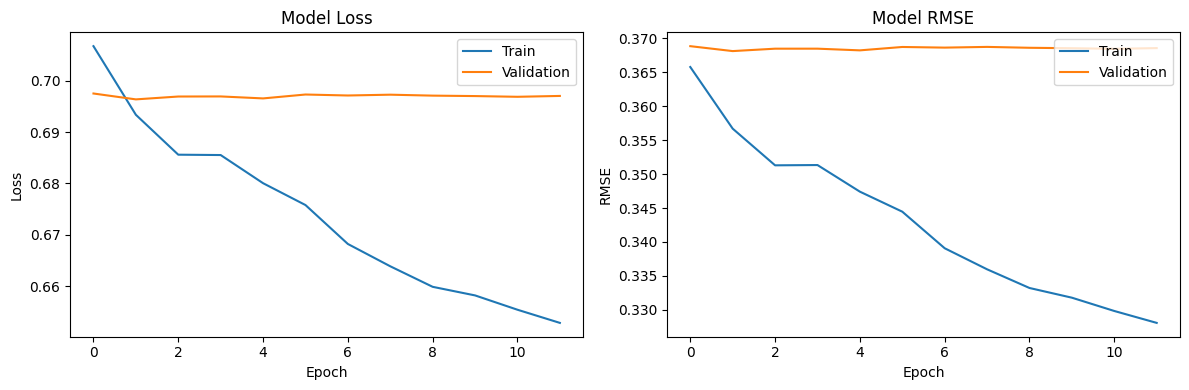

In [ ]:
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot RMSE
plt.subplot(1, 2, 2)
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Model RMSE')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

# **9. Inference**

In [ ]:
def get_tourism_recommendations(user_id, top_k=10):
    """
    Fungsi untuk mendapatkan rekomendasi tempat wisata untuk user tertentu
    """

    # Ambil places yang sudah dikunjungi user
    places_visited_by_user = df[df['user_id'] == user_id]

    # Ambil places yang belum dikunjungi
    places_not_visited = df[~df['place_id'].isin(places_visited_by_user['place_id'].values)]['place_id'].unique()

    # Filter places yang ada di encoding
    places_not_visited = list(
        set(places_not_visited).intersection(set(place_to_place_encoded.keys()))
    )

    if len(places_not_visited) == 0:
        print(f"User {user_id} sudah mengunjungi semua tempat wisata dalam dataset")
        return

    # Encode places yang belum dikunjungi
    places_not_visited_encoded = [[place_to_place_encoded.get(x)] for x in places_not_visited]

    # Encode user
    user_encoder = user_to_user_encoded.get(user_id)
    if user_encoder is None:
        print(f"User {user_id} tidak ditemukan dalam dataset")
        return

    # Buat array untuk prediksi
    user_place_array = np.hstack(
        ([[user_encoder]] * len(places_not_visited_encoded), places_not_visited_encoded)
    )

    # Prediksi rating
    ratings = model.predict(user_place_array).flatten()

    # Ambil top-k rekomendasi
    top_ratings_indices = ratings.argsort()[-top_k:][::-1]
    recommended_place_ids = [
        place_encoded_to_place.get(places_not_visited_encoded[x][0]) for x in top_ratings_indices
    ]

    # Tampilkan hasil
    print(f'Menampilkan rekomendasi untuk User: {user_id}')
    print('=' * 50)

    # Tampilkan tempat yang sudah dikunjungi dengan rating tinggi
    print('Tempat wisata dengan rating tinggi dari user:')
    print('-' * 40)

    top_places_user = (
        places_visited_by_user.sort_values(by='rating', ascending=False)
        .head(5)
        .place_id.values
    )

    for place_id in top_places_user:
        # Cari info tempat wisata (jika ada di tourism_df)
        place_info = tourism_df[tourism_df['id'] == place_id]
        if not place_info.empty:
            place_name = place_info.iloc[0]['nama_tempat']
            place_category = place_info.iloc[0]['kategori']
            user_rating = places_visited_by_user[places_visited_by_user['place_id'] == place_id]['rating'].iloc[0]
            print(f"- {place_name} ({place_category}) - Rating user: {user_rating}")
        else:
            user_rating = places_visited_by_user[places_visited_by_user['place_id'] == place_id]['rating'].iloc[0]
            print(f"- Place ID {place_id} - Rating user: {user_rating}")

    print('-' * 40)
    print(f'Top {top_k} Rekomendasi Tempat Wisata:')
    print('-' * 40)

    for i, place_id in enumerate(recommended_place_ids, 1):
        # Cari info tempat wisata (jika ada di tourism_df)
        place_info = tourism_df[tourism_df['id'] == place_id]
        if not place_info.empty:
            place_name = place_info.iloc[0]['nama_tempat']
            place_category = place_info.iloc[0]['kategori']
            place_rating = place_info.iloc[0]['rating']
            predicted_rating = ratings[top_ratings_indices[i-1]]
            print(f"{i}. {place_name} ({place_category})")
            print(f"   Rating rata-rata: {place_rating}, Prediksi rating user: {predicted_rating:.3f}")
        else:
            predicted_rating = ratings[top_ratings_indices[i-1]]
            print(f"{i}. Place ID {place_id} - Prediksi rating: {predicted_rating:.3f}")

# ========== CONTOH PENGGUNAAN ==========

# Ambil sample user untuk demo
sample_user = df['user_id'].sample(1).iloc[0]
print(f"\n=== DEMO REKOMENDASI ===")
get_tourism_recommendations(sample_user, top_k=5)

# Atau test dengan user tertentu yang ada di dataset
print(f"\n=== REKOMENDASI UNTUK USER 39 ===")
get_tourism_recommendations(39, top_k=5)


=== DEMO REKOMENDASI ===
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Menampilkan rekomendasi untuk User: 84
Tempat wisata dengan rating tinggi dari user:
----------------------------------------
- Gunung Sibayak (Gunung) - Rating user: 5.0
- Tugu Perjuangan (Monumen) - Rating user: 5.0
- Istana Kaldera Unesco Geopark Danau Toba (Wisata Edukasi) - Rating user: 4.0
- Bukit Sipisopiso (Gunung) - Rating user: 4.0
- WISATA ALAM KASIH (Wisata Religi) - Rating user: 3.0
----------------------------------------
Top 5 Rekomendasi Tempat Wisata:
----------------------------------------
1. Wisata Sawah Pematang Johar (Agrowisata)
   Rating rata-rata: 4.3, Prediksi rating user: 0.694
2. Penatapen Doulu (Gardu Pandang)
   Rating rata-rata: 4.5, Prediksi rating user: 0.694
3. TAMAN WISATA DANAU SIOMBAK MARELAN (Danau)
   Rating rata-rata: 4.0, Prediksi rating user: 0.692
4. Danau Aek Natonang (Danau)
   Rating rata-rata: 4.4, Prediksi rating user: 0.690
5. Air Terjun Sigura-Gura (Air Terjun)
   Rating ra

# **10. Saved Model**

In [ ]:
import os
import json

os.makedirs('model/cf', exist_ok=True)
model.export('model/cf', include_optimizer=False)
print("✅ SavedModel ready at model/cf")

!pip install tensorflowjs

!tensorflowjs_converter --input_format=tf_saved_model model/cf model/tfjs_model/
print("✅ TFJS model ready at model/tfjs_model/")

!pip freeze > model/requirements.txt
print("✅ Saved requirements.txt")

encoders = {
    "user_to_user_encoded": user_to_user_encoded,
    "place_to_place_encoded": place_to_place_encoded,
    "user_encoded_to_user": user_encoded_to_user,
    "place_encoded_to_place": place_encoded_to_place
}

# Tulis ke JSON
with open('model/encoders.json', 'w') as f:
    json.dump(encoders, f, indent=2)

print("✅ Encoders saved to model/encoders.json")

import shutil

# Zip folder model menjadi cbf_encoder.zip
shutil.make_archive('model_cf', 'zip', 'model')

from google.colab import files
files.download('model_cf.zip')

Saved artifact at 'model/cf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  133945419923280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133945419923088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133945373114448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133945373115984: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ SavedModel ready at model/cf
2025-06-09 06:55:01.943226: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749452101.972249   12006 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749452101.979903   12006 cuda_blas.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>